# Homework 6

## References

+ Lectures 21-23 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

If on Google Colab, install the following packages:

In [1]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

def sample_functions(mean_func, kernel_func, num_samples=10, num_test=100, nugget=1e-3):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = kernel_func.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label='mean')
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5,
                label='sample' if i == 0 else None
            )
    plt.legend(loc='best', frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-5, 5)
    sns.despine(trim=True);


import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10,
    xlabel='$x$',
    ylabel='$y$'
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    xlabel      --  The x-axis label.
    ylabel      --  The y-axis label.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'k.',
            markersize=1,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='Posterior mean',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='Epistemic uncertainty',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='Aleatory uncertainty'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return dict(m_star=m_star, v_star=v_star, ax=ax)


def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print(loss)
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()


## Student details

+ **First Name:** Qixian
+ **Last Name:** Wang
+ **Email:** qixianw2@illinois.edu

## Problem 1 - Defining priors on function spaces

In this problem, we will explore further how Gaussian processes can be used to define probability measures over function spaces.
To this end, assume that there is a 1D function, call if $f(x)$, which we do not know.
For simplicity, assume that $x$ takes values in $[0,1]$.
We will employ Gaussian process regression to encode our state of knowledge about $f(x)$ and sample some possibilities.
For each of the cases below:
+ Assume that $f\sim \operatorname{GP}(m, k)$ and pick a mean ($m(x)$) and a covariance function $f(x)$ that match the provided information.
+ Write code that samples a few times (up to five) the values of $f(x)$ at 100 equidistant points between 0 and 1.

### Part A - Super smooth function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -4 and 4.

**Answer:**

**I am doing this for you so that you have a concrete example of what is requested.**

The mean function should be:

$$
m(x) = 0.
$$

The covariance function should be a squared exponential:

$$
k(x,x') = s^2\exp\left\{-\frac{(x-x')^2}{2\ell^2}\right\},
$$

with variance:

$$
s^2 = k(x,x) = \mathbb{V}[f(x)] = 4,
$$

and lengthscale $\ell = 0.1$.
We chose the variance to be 4.0 so that with (about) 95% probability, the values of $f(x)$ are between -4 and 4.

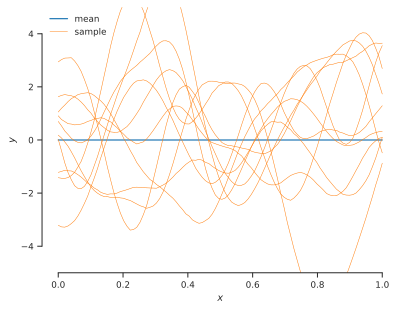

In [5]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 4.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part B - Super smooth function with known ultra-small length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.05$.
+ You think that $f(x)$ is between -3 and 3.

**Answer:**

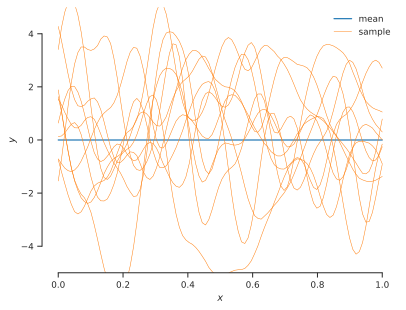

In [6]:
# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 3.0
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part C - Continuous function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is continuous, nowhere differentiable.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.MaternKernel`` with $\nu=1/2$.

**Answer:**

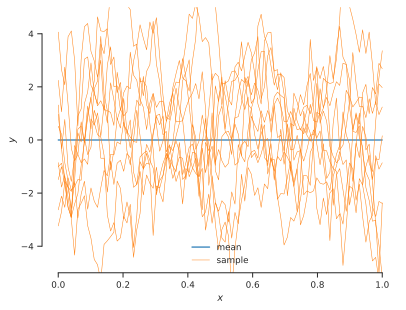

In [8]:
from gpytorch.kernels import MaternKernel
# Define the covariance function
k = ScaleKernel(MaternKernel(nu=0.5))
k.outputscale = 5.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part D - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.5$ of the period.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.

**Answer:**

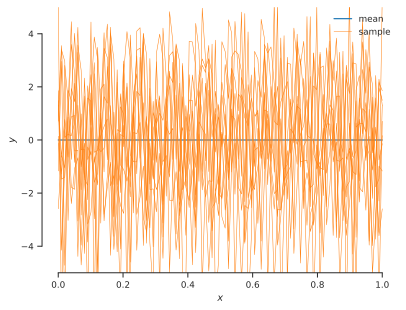

In [20]:
from gpytorch.kernels import PeriodicKernel
# Define the covariance function
k = ScaleKernel(PeriodicKernel())
k.base_kernel.period_length  = 0.1
k.outputscale = 5.0
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part E - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$ of the period (**the only thing that is different compared to D**).
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.


**Answer:**

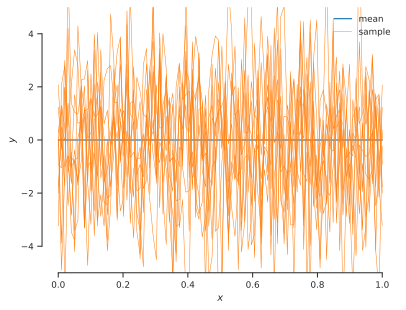

In [21]:
from gpytorch.kernels import PeriodicKernel
# Define the covariance function
k = ScaleKernel(PeriodicKernel())
k.base_kernel.period_length  = 0.1
k.outputscale = 5.0
k.base_kernel.lengthscale = 0.01

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part F - The sum of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x) + f_2(x)$, where:
    - $f_1(x)$ is smooth with variance 2 and length scale 0.5
    - $f_2(x)$ is continuous, nowhere differentiable with variance 0.1 and length scale 0.1

Hint: Use must create a new covariance function that is the sum of two other covariances.

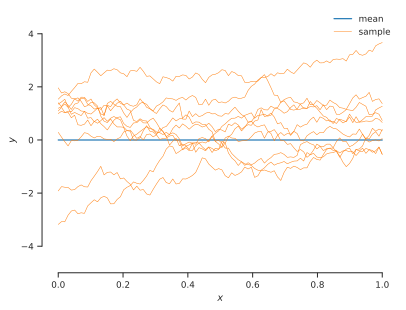

In [22]:
k1 = ScaleKernel(RBFKernel())
k1.outputscale = 2.0
k1.base_kernel.lengthscale = 0.5

k2 = ScaleKernel(MaternKernel(nu=0.5))
k2.outputscale = 0.1
k2.base_kernel.lengthscale = 0.1

kernel = k1 + k2

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, kernel, nugget=1e-4)

### Part G - The product of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x)f_2(x)$, where:
    - $f_1(x)$ is smooth, periodic (period = 0.1), length scale 0.1 (relative to the period), and variance 2.
    - $f_2(x)$ is smooth with length scale 0.5 and variance 1.

Hint: Use must create a new covariance function that is the product of two other covariances.

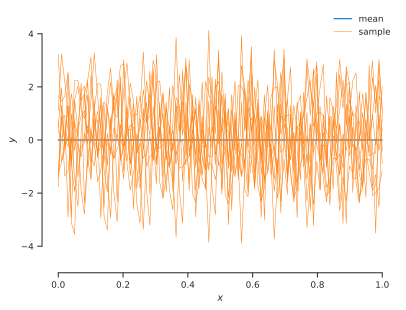

In [23]:
k1 = ScaleKernel(PeriodicKernel())
k1.base_kernel.period_length  = 0.1
k1.outputscale = 2
k1.base_kernel.lengthscale = 0.1

k2 = ScaleKernel(RBFKernel())
k2.outputscale = 1
k2.base_kernel.lengthscale = 0.5

kernel = k1 * k2

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, kernel, nugget=1e-4)

## Problem 2

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start in March 1958 and go back to January 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python cell below downloads and plots the data set.

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/mauna_loa_co2.txt"
download(url)

In [ ]:
data = np.loadtxt('mauna_loa_co2.txt')

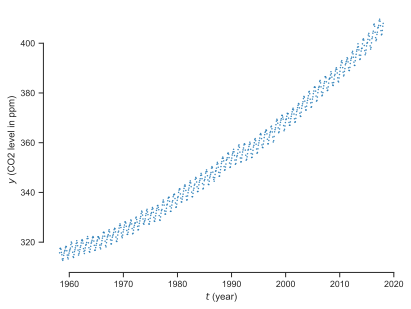

In [ ]:
#load data
t = data[:, 2]  #time (in decimal dates)
y = data[:, 4]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, 1)
ax.plot(t, y, '.', markersize=1)
ax.set_xlabel('$t$ (year)')
ax.set_ylabel('$y$ (CO2 level in ppm)')
sns.despine(trim=True);

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since most of the population inhabits the northern hemisphere, fuel consumption increases during the northern winters, and CO2 emissions follow. Our goal is to study this dataset with Gaussian process regression. Specifically, we would like to predict the evolution of the CO2 levels from Feb 2018 to Feb 2028 and quantify our uncertainty about this prediction.

Working with a scaled version of the inputs and outputs is always a good idea. We are going to scale the times as follows:

$$
t_s = t - t_{\min}.
$$

So, time is still in fractional years, but we start counting at zero instead of 1950.
We scale the $y$'s as:

$$
y_s = \frac{y - y_{\min}}{y_{\max}-y_{\min}}.
$$

This takes all the $y$ between $0$ and $1$.
Here is what the scaled data look like:

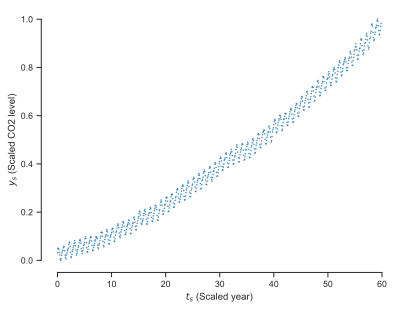

In [ ]:
t_s = t - t.min()
y_s = (y - y.min()) / (y.max() - y.min())
fig, ax = plt.subplots(1, 1)
ax.plot(t_s, y_s, '.', markersize=1)
ax.set_xlabel('$t_s$ (Scaled year)')
ax.set_ylabel('$y_s$ (Scaled CO2 level)')
sns.despine(trim=True);

Work with the scaled data in what follows as you develop your model.
Scale back to the original units for your final predictions.

## Part A - Naive approach

Use a zero mean Gaussian process with a squared exponential covariance function to fit the data and make the required prediction (ten years after the last observation).

**Answer:**

**Again, this is done for you so that you have a concrete example of what is requested.**

In [ ]:
cov_module = ScaleKernel(RBFKernel())
mean_module = gpytorch.means.ConstantMean()
train_x = torch.from_numpy(t_s).float()
train_y = torch.from_numpy(y_s).float()
naive_model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(naive_model, train_x, train_y)

tensor(0.8545, grad_fn=<NegBackward0>)
tensor(0.7392, grad_fn=<NegBackward0>)
tensor(-0.5164, grad_fn=<NegBackward0>)
tensor(-1.7390, grad_fn=<NegBackward0>)
tensor(-2.1109, grad_fn=<NegBackward0>)
tensor(-2.2523, grad_fn=<NegBackward0>)
tensor(-2.0013, grad_fn=<NegBackward0>)
tensor(-2.2894, grad_fn=<NegBackward0>)
tensor(-2.3039, grad_fn=<NegBackward0>)
tensor(-2.3159, grad_fn=<NegBackward0>)
tensor(-2.3302, grad_fn=<NegBackward0>)
tensor(-2.3335, grad_fn=<NegBackward0>)
tensor(-2.2837, grad_fn=<NegBackward0>)
tensor(-2.3380, grad_fn=<NegBackward0>)
tensor(-2.3401, grad_fn=<NegBackward0>)
tensor(-2.3443, grad_fn=<NegBackward0>)
tensor(-2.3464, grad_fn=<NegBackward0>)
tensor(-2.3477, grad_fn=<NegBackward0>)
tensor(-2.3481, grad_fn=<NegBackward0>)
tensor(-2.3505, grad_fn=<NegBackward0>)
tensor(-2.3518, grad_fn=<NegBackward0>)
tensor(-2.3526, grad_fn=<NegBackward0>)
tensor(-2.3527, grad_fn=<NegBackward0>)
tensor(-2.3529, grad_fn=<NegBackward0>)
tensor(-2.3531, grad_fn=<NegBackward0>)
It

Predict everything:

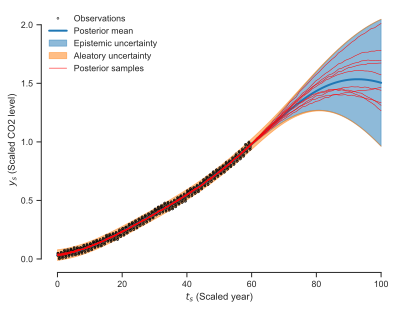

In [ ]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=naive_model, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

Notice that the squared exponential covariance captures the long terms but fails to capture the seasonal fluctuations. The seasonal fluctuations are treated as noise. This is wrong. You will have to fix this in the next part.

## Part B - Improving the prior covariance

Now, use the ideas of Problem 1 to develop a covariance function that exhibits the following characteristics visible in the data (call $f(x)$ the scaled CO2 level.
+ $f(x)$ is smooth.
+ $f(x)$ has a clear trend with a multi-year length scale.
+ $f(x)$ has seasonal fluctuations with a period of one year.
+ $f(x)$ exhibits small fluctuations within its period.

There is more than one correct answer.

**Answer:**

In [ ]:
cov_module = # Your choice of covariance here
mean_module = # Your choice of mean here
model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(model, train_x, train_y)

Plot using the following block:

In [ ]:
plot_1d_regression(model=naive_model, x_star=train_x);

## Part C - Predicting the future

How does your model predict the future? Why is it better than the naive model?

**Answer:**
*Your answer here*
<br><br>

## Part D - Bayesian information criterion

As we have seen in earlier lectures, the Bayesian informationc criterion (BIC), see [this](https://en.wikipedia.org/wiki/Bayesian_information_criterion), can bse used to compare two models.
The criterion says that one should:
+ fit the models with maximum likelihood,
+ and compute the quantity:

$$
\text{BIC} = d\ln(n) - 2\ln(\hat{L}),
$$

where $d$ is the number of model parameters, and $\hat{L}$ the maximum likelihood.
+ pick the model with the smallest BIC.

Use BIC to show that the model you constructed in Part C is indeed better than the naïve model of Part A.

**Answer:**

In [ ]:
# Hint: You can find the parameters of a model like this
list(naive_model.hyperparameters())

[Parameter containing:
 tensor([-7.8281], requires_grad=True),
 Parameter containing:
 tensor(0.8690, requires_grad=True),
 Parameter containing:
 tensor(-1.2034, requires_grad=True),
 Parameter containing:
 tensor([[32.5616]], requires_grad=True)]

In [ ]:
m = sum(p.numel() for p in naive_model.hyperparameters())
print(m)

4


In [ ]:
# Hint: You can find the (marginal) log likelihood of a model like this
mll = gpytorch.mlls.ExactMarginalLogLikelihood(naive_model.likelihood, naive_model)
log_like = mll(naive_model(train_x), train_y)
print(log_like)

tensor(2.3863, grad_fn=<DivBackward0>)


/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [ ]:
# Hint: The BIC is
bic = -2 * log_like + m * np.log(train_x.shape[0])
print(bic)

tensor(21.5389, grad_fn=<AddBackward0>)


In [ ]:
# Your code here

## Problem 3 - Bayesian Global Optimization

As a toy example, we will apply Bayesian Optimization to some synthetic data. We will study the classic [Forrester function](https://www.sfu.ca/~ssurjano/forretal08.html)

$$
f(x) = (6x - 2)^2\sin(12x - 4)
$$

on the domain $[0,1]$. We will also $\textit{standardize}$ the output of the function, such that it has a mean of $0$ and a standard deviation of $1$. This is a good habit to get into when working with Gaussian processes. We will stick to a zero mean prior, so ensuring that the data has a mean of zero aligns with this.

The mean and standard deviation of this function on $[0,1]$ are known:
$$
\begin{aligned}
 \mu &= 0.45321 \\
 \mathrm{std} &= 4.4248
\end{aligned}
$$

The goal is to find the minimum of this objective function.

### Part A - Visualize the function and generate some data

Let's visualize the ground truth objective function and our synthetic data. First, code the **standardized** Forrester function in a way that allows for **minimization** using our Bayesian global **maximization** algorithms from the lecture book.

(Hint: to minimize a function, you can maximize the negative of that function)

In [ ]:
# your code here
def Forrester(x):
    """ground truth function to optimize"""

    return

In [ ]:
# making synthetic data from your function

np.random.seed(539)

sigma_noise = 0.025

# noisy version of the above function
F_noisy = lambda x: (
    Forrester(x)
    + sigma_noise * np.random.randn(x.shape[0])
)

# generate synthetic data
n_init = 5
X = np.random.rand(n_init)
Y = F_noisy(X)

train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

Plot it on $[0,1]$ and make sure to include the data points

In [ ]:
# your code here
xs = np.linspace(0, 1, 100)

### Part B - Set up the Gaussian process model

Set up the Gaussian process model.

Specifically, use this:

1. A Matern covariance kernel
2. Zero mean function
3. A Gaussian likelihood model
4. Set the likelihood noise to the ground truth noise (since we assume it is known)

In [ ]:
# your code here

### Now train the model on the data points to optimize the rest of the hyperparameters

Here is the training function you should be using:

In [ ]:
def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()

In [ ]:
# your code here

### Plot the trained model along with some sample paths

In [ ]:
# your code here

### Plot the uncertainty about the optimization problem for the initial Gaussian process surrogate

In [ ]:
# your code here

## Part C - Expected improvement with noise

Solve the optimization problem by applying the expected improvement with noise algorithm

In [ ]:
def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return m_star, v_star

def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None,
    iaf_label="Information Acquisition Function"
):
    """Plot the information acquisition function.

    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.

    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    alpha_params -- Extra parameters to the information
                    acquisition function.
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    iaf_label    -- The label for the information acquisition
                    function. Default is "Information Acquisition".

    The evaluation of the information acquisition function
    is as follows:

        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )

    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )

    sigma = torch.sqrt(v)
    af_values = alpha(m, sigma, gpr.train_targets.numpy().max(), **alpha_params)
    next_id = torch.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]

    ax2 = ax.twinx()
    ax2.plot(x_star, af_values.detach(), color=sns.color_palette()[1])
    ax2.set_ylabel(
        iaf_label,
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        torch.linspace(0, af_max.item(), 100),
        color=sns.color_palette()[1],
        linewidth=1
    )

def ei(m, sigma, ymax):
    """Return the expected improvement.

    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymin  -- The minimum observed value (so far).
    """
    diff = m - ymax
    u = diff / sigma
    ei = ( diff * torch.distributions.Normal(0, 1).cdf(u) +
          sigma * torch.distributions.Normal(0, 1).log_prob(u).exp()
    )
    ei[sigma <= 0.] = 0.
    return ei

def maximize(
    f,
    model,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.

    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowledge.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.

    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.

    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        f_design = model(X_design)
        m = f_design.mean
        sigma2 = f_design.variance
        sigma = torch.sqrt(sigma2)

        # Evaluate information acquisition function
        y_train = model.train_targets.numpy()
        af_values = alpha(
            m,
            sigma,
            y_train.max(),
            **alpha_params
        )

        # Find best point to include
        i = torch.argmax(af_values)
        af_all.append(af_values[i])

        new_x = X_design[i:(i+1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)

        if optimize:
            train(model, train_x, train_y, n_iter=100, lr=0.1)
        else:
            model.train()
            model.eval()

        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                model,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax,
                **kwargs
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all

### run the algorithm

In [ ]:
# your code here

### How many iterations does the algorithm take to converge? That is, how quickly does it identify the critical point?

Your answer here

### Quantify the uncertainty about the solution to the optimization problem with the trained Gaussian process

Your answer here

## Part D - Testing your intuition

In a real-world scenario, you may not be able to keep running experiments until the optimization problem has obviously converged due to time, budget considerations, etc. Imagine yourself in a situation where you are deciding whether or not to query the blackbox function an additional time.

Describe (in words) how you could make this decision using the principles you've learned in this course.